 <h1><center>Multi-class Classification of Customer Service Questions categories</center></h1>

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#Section_1"> Importing Required Libraries and Data</a></li>
        <li><a href="#Section_2"> Preprocessing - creating clean text column</a></li>
        <li><a href="#Section_3"> Train test Split </a> </li>
        <li><a href="#Section_4"> Text Vectorisation</a></li>
        <li><a href="#Section_5"> Models and metrics</a></li>
        <li><a href="#Section_6"> Observations</a></li>
    </ol>
</div>

<h2 id="#Section_1"> 1. Importing Required Libraries and Data</h2>

In [1]:
import pandas as pd
import nltk
import warnings; 
warnings.simplefilter('ignore')
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saisu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
CS_df = pd.read_csv("Customer_Service_Questions_Multiclass.csv") # importing csv into a dataframe
CS_df.shape
CS_df.head(2)

,question,topic
0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions
1,I'm going to be out of the country for about a...,Shipping


In [3]:
CS_df['topic'].value_counts()

Product Specifications    839
Product Availability      833
Product Comparison        806
Shipping                  799
Returns & Refunds         768
Sales/Promotions          505
Omnichannel               450
Name: topic, dtype: int64

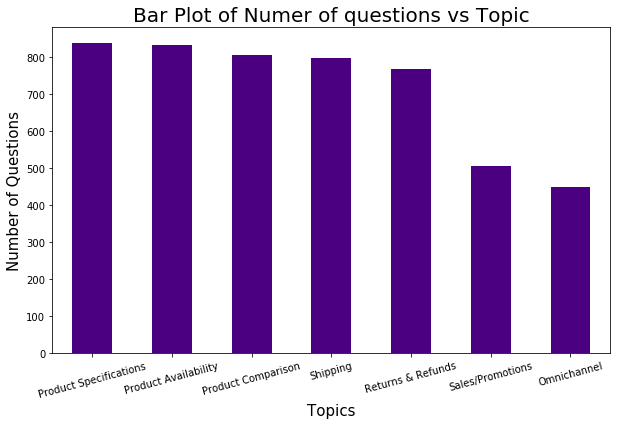

In [4]:
ax = CS_df['topic'].value_counts().plot(kind='bar', figsize=(10,6), color="indigo", fontsize=10,rot=15)
ax.set_alpha(0.5)
ax.set_title("Bar Plot of Numer of questions vs Topic", fontsize=20)
ax.set_ylabel("Number of Questions", fontsize=15);
ax.set_xlabel("Topics", fontsize=15);

### The questions in the dataset are spread over 7 topics, with Product Specification related being highest and Omnichannel being least.

<h2 id="#Section_2"> 2. Preprocessing - creating clean text column </h2>

In [5]:
#function to clean text in a column returns list of rows as cleaned text 
def Clean_df(df_Col):
    lemmatizer = WordNetLemmatizer()
    clean_list = []
    for text in df_Col:
        words = regexp_tokenize(text.lower(), r'[A-Za-z]+')
        words = [w for w in words if len(w)>1 and w not in stopwords.words('english')]
        words = [lemmatizer.lemmatize(w) for w in words]
        clean_list.append(' '.join(words))
    return clean_list

In [6]:
CS_df['clean_col'] = Clean_df(CS_df['question'])
CS_df.drop(columns='question',inplace=True)
CS_df.head()

,topic,clean_col
0,Sales/Promotions,hi sign email list select get email exclusivel...
1,Shipping,going country week travel going getting animal...
2,Shipping,wondering able overnight jacket item trenton nj
3,Shipping,swingline electronic stapler look really great...
4,Shipping,think cosmetic bag would work great however kn...


<h2 id="#Section_3"> 3. Train Test Split and encoding Category </h2>

In [7]:
# strartify Split data into train and test 
def train_test_stratify_split(X,Y):
    from sklearn.model_selection import train_test_split
    train_x, test_x, train_y, test_y = train_test_split(X, Y,stratify=Y, test_size=0.2, random_state=42)
    return train_x, test_x, train_y, test_y

train_x, test_x, train_y, test_y=train_test_stratify_split(CS_df['clean_col'],CS_df['topic'])

In [8]:
#encoding a column
def col_encoding(to_fit,to_transform):
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    to_fit = encoder.fit_transform(to_fit)
    to_transform = encoder.transform(to_transform)
    classes=encoder.inverse_transform(np.unique(to_fit))
    return to_fit,to_transform,classes
train_y,test_y,classes=col_encoding(train_y,test_y)

In [9]:
#7-Classes encoded from 0 to 6 
classes

array(['Omnichannel', 'Product Availability', 'Product Comparison',
       'Product Specifications', 'Returns & Refunds', 'Sales/Promotions',
       'Shipping'], dtype=object)

<h2 id="#Section_4"> 4. Text Vector creation </h2>

Trying different Vectorization techniques.

CountVectorizer only counts the number of times a word appears in the document resulting in bias of most frequent words and ignoring rare words, TfidfVectorizer considers overall document weightage of a word thus help finding most frequent words to penalise. It weights the word counts by a measure of how often they appear in the documents. With n-gram TF-IDF, we can also weigh in co-occuraning words in each document. But these Vectorisors(Bag of Words methods) doesn't capture position and meaning/context of the text. I used TF-IDF over Word2vec because of its simple Ease of use and smaller corpus.

### BOW Vectorisation

In [10]:
#create TF-IDF vectorizer with n-gram
def tfidf_ngram(df_col,X,Y):
    from sklearn.feature_extraction.text import TfidfVectorizer
    tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}',ngram_range=(2,3))#, max_features=5000)
    tfidf_vect.fit(df_col)
    xtrain_tfidf =  tfidf_vect.transform(X)
    xtest_tfidf =  tfidf_vect.transform(Y)
    return xtrain_tfidf,xtest_tfidf,tfidf_vect

In [11]:
#train test split of features and predictors
xtrain_tfidf,xtest_tfidf,tfidf_vect=tfidf_ngram(CS_df['clean_col'],train_x,test_x)

<h2 id="#Section_5"> 5. Classification Models and their metrics </h2>

In [12]:
#metrics function for models
from sklearn.metrics import accuracy_score, precision_score, recall_score,roc_auc_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report  
import seaborn as sns
import matplotlib.pyplot as plt
def model(classifier, train_features, test_features):
    if classifier in (MultinomialNB,RandomForestClassifier,kn_clf):
        predict_y = classifier.predict(test_features)        
    else:
        predict_y = classifier.predict_classes(test_features)
    predicted_prob = classifier.predict_proba(test_features)
    y_test_array = pd.get_dummies(test_y, drop_first=False).values
    print('classification_report\n',classification_report(test_y, predict_y))
    print('Confusion Matrix')
    cm=confusion_matrix(test_y, predict_y)    
    print('AUC: {:.3f}\n'.format(roc_auc_score(test_y, predicted_prob,multi_class="ovr")))
    fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(30,5))
    
    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                               predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(fpr, tpr))
                   )
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[i], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    
    
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[2], cmap=plt.cm.Blues, 
            cbar=False)
    ax[2].set(xlabel="Pred", ylabel="True", xticklabels=classes,
       yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.show()
    return

### NaiveBayes Classifier

In [13]:
#grid search for best hyperparameters
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
grid_params = {
  'alpha': np.linspace(0.5, 1.5, 6),
  'fit_prior': [True, False], 
}
clf = GridSearchCV(MultinomialNB(), grid_params)
clf.fit(xtrain_tfidf, train_y)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Best Score:  0.92275
Best Params:  {'alpha': 0.5, 'fit_prior': True}


In [14]:
# Naive Bayes: N-Gram level TF-IDF and word2vec
from sklearn.naive_bayes import MultinomialNB
MultinomialNB=MultinomialNB(alpha= 0.5, fit_prior= True)
MultinomialNB.fit(xtrain_tfidf,train_y)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

### KNN Classifier

In [15]:
from sklearn.neighbors import KNeighborsClassifier
kn_clf = KNeighborsClassifier(10)
kn_clf.fit(xtrain_tfidf, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

### RandomForest Classifier

In [27]:
#Random Grid Search for Random-Forest Bagging Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
grid_params ={
 'bootstrap': [True, False],
 'max_depth': [10, 20, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 50, 60, 70, 80,90]
}

clf = RandomizedSearchCV(RandomForestClassifier(), grid_params)
clf.fit(xtrain_tfidf, train_y)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Best Score:  0.8757499999999998
Best Params:  {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


In [16]:
# Random Forest (Bagging Model): Word-Level n-gram TF-IDF
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifier=RandomForestClassifier(n_estimators= 100, 
                                              min_samples_split= 2, 
                                              min_samples_leaf= 1, 
                                              max_features= 'sqrt', 
                                              max_depth= None, 
                                              bootstrap= False,random_state=42)
RandomForestClassifier.fit(xtrain_tfidf,train_y)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### Deep Neural Network Classifier

In [17]:
#For Neural networks Sparse vector cannot perform well and takes long time. using PCA or SVD to reduce dimensionality
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=500, n_iter=7, random_state=42)
X_train_new2=svd.fit_transform(xtrain_tfidf)
X_test_new2=svd.transform(xtest_tfidf)

In [18]:
from sklearn.datasets import fetch_20newsgroups
from keras.layers import  Dropout, Dense
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn import metrics
def Build_Model_DNN_Text(shape, nClasses, dropout=0.25):
    model = Sequential()
    node = 512 # number of nodes
    nLayers = 4 # number of  hidden layer
    model.add(Dense(node,input_dim=shape,activation='relu'))
    model.add(Dropout(dropout))
    for i in range(0,nLayers):
        model.add(Dense(node,input_dim=node,activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(nClasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

Using TensorFlow backend.


In [19]:
model_DNN = Build_Model_DNN_Text(X_train_new2.shape[1], 7)
model_DNN.fit(X_train_new2, train_y,
                              validation_split=0.2,
                              epochs=10,
                              batch_size=32,
                              verbose=2)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
 - 3s - loss: 1.4002 - accuracy: 0.4222 - val_loss: 0.6118 - val_accuracy: 0.7850
Epoch 2/10
 - 2s - loss: 0.3966 - accuracy: 0.8531 - val_loss: 0.3254 - val_accuracy: 0.8813
Epoch 3/10
 - 2s - loss: 0.2495 - accuracy: 0.9062 - val_loss: 0.2859 - val_accuracy: 0.9062
Epoch 4/10
 - 2s - loss: 0.2224 - accuracy: 0.9175 - val_loss: 0.2672 - val_accuracy: 0.9000
Epoch 5/10
 - 2s - loss: 0.2093 - accuracy: 0.9222 - val_loss: 0.2641 - val_accuracy: 0.8938
Epoch 6/10
 - 2s - loss: 0.1963 - accuracy: 0.9262 - val_loss: 0.2726 - val_accuracy: 0.9062
Epoch 7/10
 - 2s - loss: 0.1721 - accuracy: 0.9384 - val_loss: 0.2757 - val_accuracy: 0.9087
Epoch 8/10
 - 2s - loss: 0.1645 - accuracy: 0.9406 - val_loss: 0.3620 - val_accuracy: 0.8900
Epoch 9/10
 - 2s - loss: 0.1651 - accuracy: 0.9400 - val_loss: 0.3338 - val_accuracy: 0.8963
Epoch 10/10
 - 3s - loss: 0.1487 - accuracy: 0.9456 - val_loss: 0.2722 - val_accuracy: 0.9075


### Metrics

classification_report
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        90
           1       0.97      0.87      0.91       167
           2       1.00      0.74      0.85       161
           3       0.68      0.99      0.80       168
           4       1.00      0.99      0.99       153
           5       1.00      0.86      0.93       101
           6       0.99      0.99      0.99       160

    accuracy                           0.91      1000
   macro avg       0.95      0.91      0.92      1000
weighted avg       0.94      0.91      0.92      1000

Confusion Matrix
AUC: 0.981



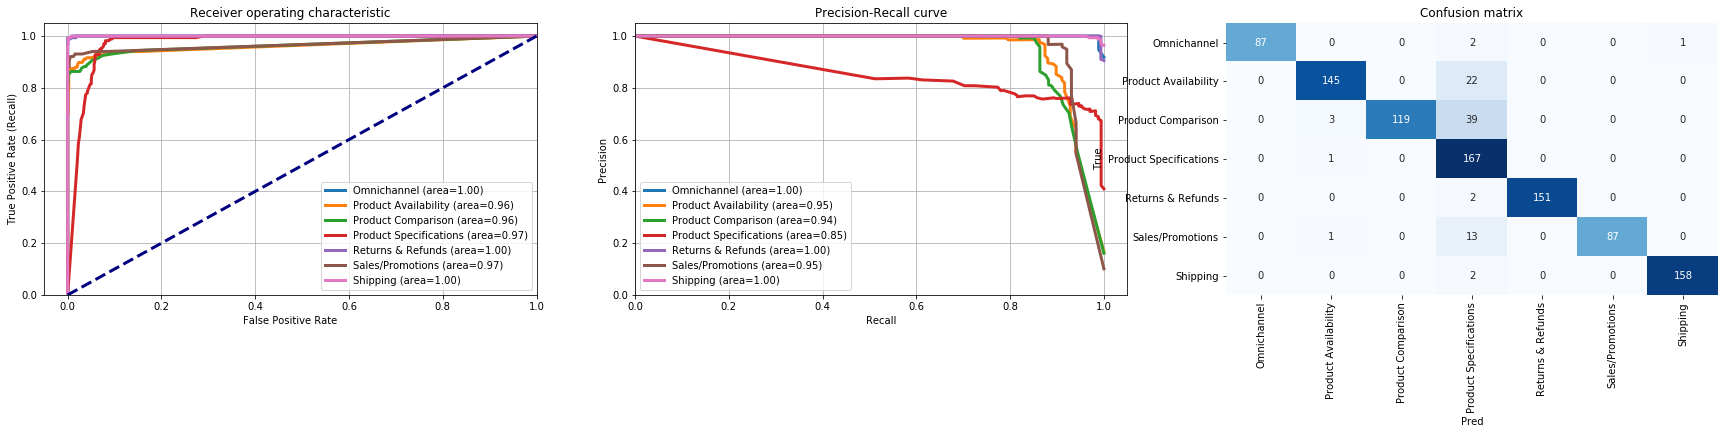

---------------------------------------------------------------------------------------------------
classification_report
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        90
           1       0.87      0.74      0.80       167
           2       0.87      0.71      0.78       161
           3       0.78      0.78      0.78       168
           4       0.70      0.99      0.82       153
           5       0.93      0.83      0.88       101
           6       0.95      0.96      0.96       160

    accuracy                           0.84      1000
   macro avg       0.87      0.85      0.85      1000
weighted avg       0.86      0.84      0.84      1000

Confusion Matrix
AUC: 0.969



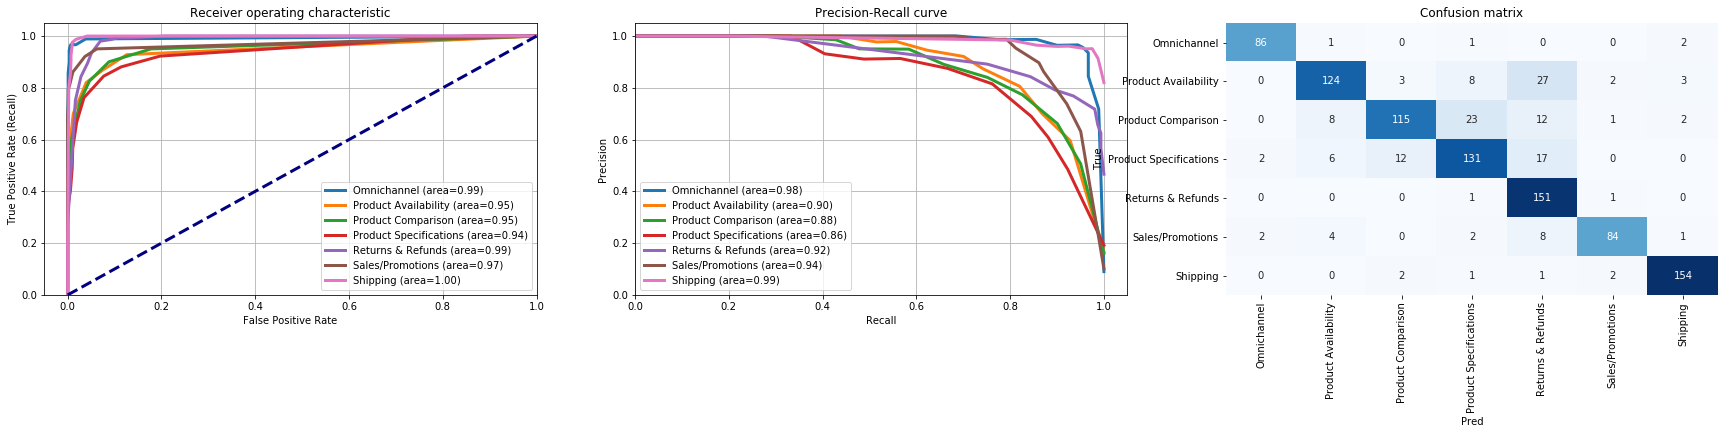

---------------------------------------------------------------------------------------------------
classification_report
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        90
           1       0.86      0.95      0.90       167
           2       0.94      0.84      0.89       161
           3       0.85      0.88      0.87       168
           4       0.96      0.99      0.98       153
           5       1.00      0.90      0.95       101
           6       0.98      0.99      0.98       160

    accuracy                           0.93      1000
   macro avg       0.94      0.93      0.94      1000
weighted avg       0.93      0.93      0.93      1000

Confusion Matrix
AUC: 0.995



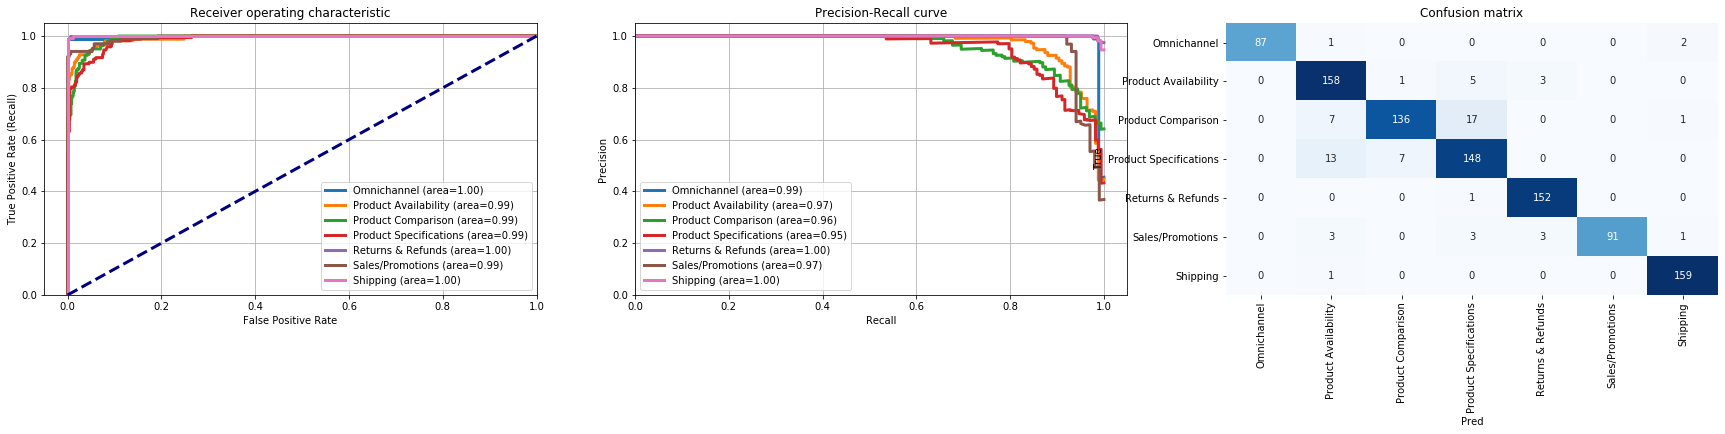

---------------------------------------------------------------------------------------------------
classification_report
               precision    recall  f1-score   support

           0       0.89      0.97      0.93        90
           1       0.87      0.84      0.86       167
           2       0.95      0.66      0.78       161
           3       0.65      0.94      0.77       168
           4       0.97      0.99      0.98       153
           5       1.00      0.74      0.85       101
           6       1.00      0.96      0.98       160

    accuracy                           0.87      1000
   macro avg       0.90      0.87      0.88      1000
weighted avg       0.90      0.87      0.87      1000

Confusion Matrix
AUC: 0.991



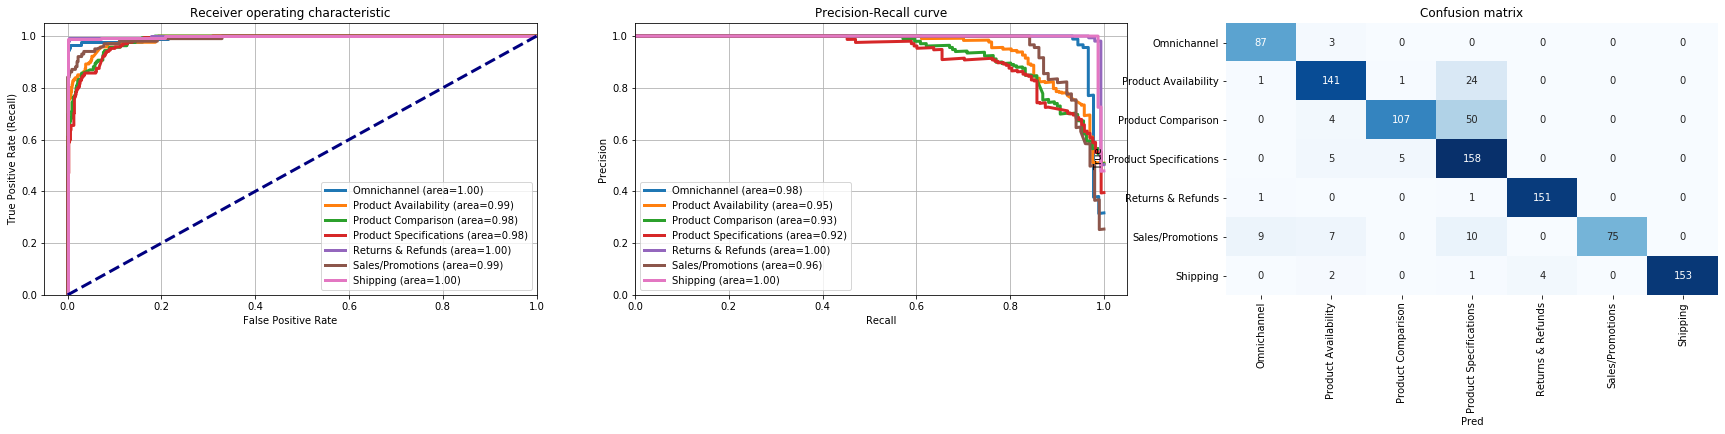

In [20]:
model(RandomForestClassifier, xtrain_tfidf, xtest_tfidf)
print('---------------------------------------------------------------------------------------------------')
model(kn_clf, xtrain_tfidf, xtest_tfidf)
print('---------------------------------------------------------------------------------------------------')
model(MultinomialNB, xtrain_tfidf, xtest_tfidf)
print('---------------------------------------------------------------------------------------------------')
model(model_DNN, X_train_new2, X_test_new2)

-> Accuracy is not a good metric, because it performs poor on imbalanced dataset. 

-> Whereas Precision, recall and F1-score are good metrics for classification even if there is any imbalance representation of predicted class in datset. Classification report gives us thes metics. 

-> Confusion matrix gives us visual representation of model performance and comparision between True and predicted classes, Other metrics F1,Precison,recall are calculated from Concusion matrix.

-> AUC-ROC(Area under the curve of reciever characterstic operator) is another metric for classification problems, which is a probability curve that plots True Positive rate aganist False positive rate at various thresholds for each of the Classes. AUC is the ability to measure the ability classifier to distinguish between classes.Also a Summary to ROC.

From  the above models(Naive Bayes, Random Forest, K-nearest Neighbour, Deep Neural Network)-

Naive bayes worked best on holdout dataset with weighted avg F1 score of 0.93 compared to Random forest, KNN and DNN with F1 score of 0.92, 0.84, 0.88 respectively.

when it comes to AUC- Naive bayes performed well with an AUC of 0.99 compared to Random forest 0.98, KNN 0.96 and DNN- 0.98

New models implemented-KNN,DNN

## Out of sample Prediction Example
To test classifiers built with out of sample example try - "The shoe color is not good."- should belong to product specification

In [21]:
text = ["The shoe color is not good."]
text_features = tfidf_vect.transform(text)
RF_Pred = RandomForestClassifier.predict(text_features)
Knn_Pred = kn_clf.predict(text_features)
NB_Pred = MultinomialNB.predict(text_features)
DNN_Pred = model_DNN.predict_classes(svd.transform(text_features))

In [22]:
classes

array(['Omnichannel', 'Product Availability', 'Product Comparison',
       'Product Specifications', 'Returns & Refunds', 'Sales/Promotions',
       'Shipping'], dtype=object)

In [23]:
print('RF prediction:',classes[RF_Pred[0]])
print('KNN prediction',classes[Knn_Pred[0]])
print('Naivebayes prediction',classes[NB_Pred[0]])
print('Deep neural network prediction',classes[DNN_Pred[0]])

RF prediction: Product Specifications
KNN prediction Returns & Refunds
Naivebayes prediction Product Specifications
Deep neural network prediction Product Specifications


Out of the models KNN performed worst. Naive Bayes with good F1 score is a Good model.

Reference- 

Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT -

https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

https://medium.com/text-classification-algorithms/text-classification-algorithms-a-survey-a215b7ab7e2d
